# Preprocesamiento de Datos
## Detección de Anomalías en Ataques de Consul Poisoning

**Fecha:** Enero 2026

---

### Contenido

1. Introducción y Estrategia
2. Configuración e Importación de Librerías
3. Carga de Datos
4. Eliminación de Variables Constantes y Baja Varianza
5. Tratamiento de Valores Nulos
6. Eliminación de Variables Altamente Correlacionadas
7. Separación de Variables y Selección de Features
8. Exportación del Dataset Limpio
9. Resumen de Transformaciones Aplicadas
10. Conclusiones

## 1. Introducción y Estrategia de Preprocesamiento

El análisis exploratorio (EDA) realizado previamente ha revelado características clave del dataset que orientan las decisiones de preprocesamiento. El objetivo de esta fase es **limpiar el dataset de ventanas deslizantes** eliminando variables que no aportan información útil para los modelos de detección de anomalías.

> **Nota:** La normalización y escalado de los datos se realizará en los notebooks de modelado específicos, ya que cada algoritmo puede requerir transformaciones diferentes.

### 1.1 Hallazgos Clave del EDA que guían el Preprocesamiento

El análisis exploratorio ha identificado los siguientes aspectos que **requieren acción en el preprocesamiento**:

| Hallazgo | Acción en Preprocesamiento |
|----------|---------------------------|
| **15 variables constantes** | Eliminar (no aportan información) |
| **30+ pares con correlación ≥ 0.95** | Eliminar redundantes |
| **Variables con baja varianza (>99% mismo valor)** | Eliminar |
| **91% de nulos en columnas `*_std`** | Imputar con 0 (ventanas con 1 conexión) |
| **Nulos en métricas temporales** | Imputar con 0 (primera conexión) |
| **Outliers = ataques** | NO eliminar, preservar |

### 1.2 Variables Identificadas para Eliminación (según EDA)

#### **1.2.1 Variables Constantes (15 variables)**
Variables identificadas en el EDA que tienen el mismo valor para todas las instancias:
- `id.resp_p_mean`, `id.resp_p_std`, `id.resp_p_max` (puerto Consul siempre 8500)
- `ja3_is_known_mean`, `ja3_is_known_std`, `ja3_is_known_max`
- `ja3_behavior_score_mean`, `ja3_behavior_score_std`, `ja3_behavior_score_max`
- `unique_ja3_from_ip_mean`, `unique_ja3_from_ip_std`, `unique_ja3_from_ip_max`
- Y otras identificadas automáticamente

#### **1.2.2 Variables con Baja Varianza**
Variables donde >99% de los valores son iguales:
- `conn_state_encoded_std` (99.9% mismo valor)
- `ja3_frequency_std` (99.1% mismo valor)

#### **1.2.3 Variables Altamente Correlacionadas (correlación ≥ 0.95)**
Pares identificados en el EDA (se elimina una de cada par):
- `conn_count_10s_mean` ↔ `conn_count_60s_mean` ↔ `conn_count_300s_mean`
- `duration_mean` ↔ `duration_max`
- `orig_bytes_mean` ↔ `resp_bytes_mean`
- Y otros ~30 pares

### 1.3 Estrategia de Preprocesamiento

```
┌─────────────────────────────────────────────────────────────────────────┐
│                    PIPELINE DE PREPROCESAMIENTO                         │
├─────────────────────────────────────────────────────────────────────────┤
│  1. Cargar datos (94 columnas)                                          │
│           ↓                                                             │
│  2. Eliminar variables constantes (-15 aprox.)                          │
│           ↓                                                             │
│  3. Eliminar variables con baja varianza (>99% mismo valor)             │
│           ↓                                                             │
│  4. Imputar nulos (*_std → 0, temporales → 0, resto → mediana)          │
│           ↓                                                             │
│  5. Eliminar variables con correlación ≥ 0.95 (-30 aprox.)              │
│           ↓                                                             │
│  6. Separar: identificadores + etiquetas + features (~39 features)      │
│           ↓                                                             │
│  7. Exportar dataset limpio (windowed_dataset_cleaned.csv)              │
└─────────────────────────────────────────────────────────────────────────┘
```

### 1.4 Modelos de Detección de Anomalías (Siguiente Fase)

El dataset limpio generado en este notebook será utilizado posteriormente por los siguientes modelos:

| Algoritmo | Tipo | Notebook |
|-----------|------|----------|
| **Isolation Forest** | Árboles | 03a_modeling_isolation_forest |
| **HDBSCAN** | Densidad | 03b_modeling_hdbscan |
| **GMM** | Probabilístico | 03c_modeling_gmm |

> Cada notebook de modelado aplicará las transformaciones de escalado/normalización específicas que requiera el algoritmo.

---

## 2. Configuración e Importación de Librerías

In [1]:
# ============================================================================
# CONFIGURACIÓN DEL ENTORNO
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Colores corporativos
COLORS = {
    'normal': '#2ecc71',
    'attack': '#e74c3c',
    'primary': '#3498db',
    'secondary': '#9b59b6',
    'warning': '#f39c12'
}

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Entorno configurado correctamente")

✓ Entorno configurado correctamente


## 3. Carga de Datos

In [3]:
# Carga del dataset
df = pd.read_csv('../../data/processed/windowed_dataset.csv')

print(f"{'='*60}")
print(f"DATASET CARGADO")
print(f"{'='*60}")
print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Guardar dimensiones originales para el resumen final
original_shape = df.shape
print(f"\n✓ Dataset cargado correctamente")

DATASET CARGADO
Dimensiones: 24,005 filas × 94 columnas
Memoria: 18.57 MB

✓ Dataset cargado correctamente


## 4. Eliminación de Variables Constantes y Baja Varianza

Según el EDA, se identificaron **15 variables constantes** y varias con **baja varianza** (>99% mismo valor) que no aportan información discriminativa.

In [4]:
# ============================================================================
# 4.1 IDENTIFICAR Y ELIMINAR VARIABLES CONSTANTES
# ============================================================================

# Identificar columnas constantes (1 único valor)
constant_cols = [col for col in df.columns if df[col].nunique(dropna=False) <= 1]

print("VARIABLES CONSTANTES IDENTIFICADAS")
print("="*60)
print(f"Total: {len(constant_cols)} variables")
if constant_cols:
    for col in constant_cols:
        unique_val = df[col].dropna().unique()
        print(f"   • {col}: valor único = {unique_val[0] if len(unique_val) > 0 else 'NaN'}")

# Eliminar variables constantes
df = df.drop(columns=constant_cols)
print(f"\n✓ Eliminadas {len(constant_cols)} variables constantes")
print(f"   Dimensiones actuales: {df.shape}")

VARIABLES CONSTANTES IDENTIFICADAS
Total: 11 variables
   • window_duration: valor único = 15.0
   • id.resp_p_mean: valor único = 8501.0
   • id.resp_p_max: valor único = 8501
   • ja3_is_known_mean: valor único = 0.0
   • ja3_is_known_max: valor único = 0
   • ja3_behavior_score_mean: valor único = 0.5
   • ja3_behavior_score_max: valor único = 0.5
   • unique_ja3_from_ip_mean: valor único = 1.0
   • unique_ja3_from_ip_max: valor único = 1
   • id.resp_h_nunique: valor único = 1
   • ja3_nunique: valor único = 1

✓ Eliminadas 11 variables constantes
   Dimensiones actuales: (24005, 83)


In [5]:
# ============================================================================
# 4.2 IDENTIFICAR Y ELIMINAR VARIABLES CON BAJA VARIANZA
# ============================================================================

# Identificar variables donde >99% de los valores son iguales
low_variance_cols = []
low_variance_details = []

for col in df.select_dtypes(include='number').columns:
    mode_ratio = df[col].value_counts(normalize=True).iloc[0] if len(df[col].value_counts()) > 0 else 1
    if mode_ratio > 0.99:  # Más del 99% es el mismo valor
        low_variance_cols.append(col)
        low_variance_details.append({
            'variable': col,
            'modo_ratio': mode_ratio,
            'valor_dominante': df[col].mode().iloc[0] if len(df[col].mode()) > 0 else None
        })

print("\nVARIABLES CON BAJA VARIANZA (>99% mismo valor)")
print("="*60)
print(f"Total: {len(low_variance_cols)} variables")
if low_variance_details:
    low_var_df = pd.DataFrame(low_variance_details)
    print(low_var_df.to_string(index=False))

# Eliminar variables con baja varianza
df = df.drop(columns=low_variance_cols)
print(f"\n✓ Eliminadas {len(low_variance_cols)} variables con baja varianza")
print(f"   Dimensiones actuales: {df.shape}")


VARIABLES CON BAJA VARIANZA (>99% mismo valor)
Total: 7 variables
              variable  modo_ratio  valor_dominante
         id.resp_p_std    1.000000              0.0
conn_state_encoded_std    0.998550              0.0
     ja3_frequency_std    0.990817              0.0
      ja3_is_known_std    1.000000              0.0
ja3_behavior_score_std    1.000000              0.0
unique_ja3_from_ip_std    1.000000              0.0
       is_known_ip_std    1.000000              0.0

✓ Eliminadas 7 variables con baja varianza
   Dimensiones actuales: (24005, 76)


## 5. Tratamiento de Valores Nulos

Según el EDA, los valores nulos tienen un significado específico:
- **Columnas `*_std`**: 91% de nulos porque el 91% de ventanas tienen solo 1 conexión (no se puede calcular desviación)
- **Columnas temporales**: Nulos representan primeras conexiones (sin historial)

In [6]:
# ============================================================================
# 5.1 ANÁLISIS DE VALORES NULOS ANTES DE IMPUTACIÓN
# ============================================================================

null_before = df.isnull().sum()
null_pct_before = (df.isnull().sum() / len(df) * 100).round(2)

null_summary_before = pd.DataFrame({
    'nulos': null_before,
    'porcentaje (%)': null_pct_before
}).sort_values('porcentaje (%)', ascending=False)

print("ANÁLISIS DE VALORES NULOS")
print("="*60)
print(f"Variables con nulos: {(null_before > 0).sum()}")
print(f"Total valores nulos: {null_before.sum():,}")
print(f"\nVariables con >5% de nulos:")
print(null_summary_before[null_summary_before['porcentaje (%)'] > 5].head(15))

ANÁLISIS DE VALORES NULOS
Variables con nulos: 22
Total valores nulos: 438,735

Variables con >5% de nulos:
                                nulos  porcentaje (%)
time_since_last_conn_std        21937           91.39
orig_bytes_std                  21936           91.38
id.orig_p_std                   21936           91.38
resp_bytes_std                  21936           91.38
duration_zscore_std             21936           91.38
conn_count_10s_std              21936           91.38
conn_count_60s_std              21936           91.38
conn_count_300s_std             21936           91.38
duration_std                    21936           91.38
conn_interval_std               21936           91.38
bytes_ratio_std                 21936           91.38
burst_score_std                 21936           91.38
recent_activity_score_std       21936           91.38
interval_stddev_std             21936           91.38
time_since_container_start_std  21936           91.38


In [7]:
# ============================================================================
# 5.2 IMPUTACIÓN DIFERENCIADA DE VALORES NULOS
# ============================================================================

# 1. Columnas de desviación estándar (*_std): NaN → 0
# Justificación: NaN indica ventanas con 1 sola conexión, donde std = 0 por definición
std_cols = [c for c in df.columns if c.endswith('_std')]
df[std_cols] = df[std_cols].fillna(0.0)
print(f"Imputadas {len(std_cols)} columnas *_std con 0")

# 2. Métricas temporales: NaN → 0
# Justificación: NaN indica primera conexión, sin conexión previa
time_cols = [c for c in df.columns if 'time_since_last_conn' in c]
if time_cols:
    df[time_cols] = df[time_cols].fillna(0.0)
    print(f"Imputadas {len(time_cols)} columnas temporales con 0")

# 3. Resto de nulos: imputar con mediana (robusto ante outliers)
remaining_null_cols = df.columns[df.isnull().any()].tolist()
if remaining_null_cols:
    print(f"\nColumnas con nulos restantes: {remaining_null_cols}")
    for col in remaining_null_cols:
        if df[col].dtype in ['float64', 'int64']:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"   • {col}: imputado con mediana = {median_val:.4f}")

# Verificación final
null_after = df.isnull().sum().sum()
print(f"\n{'='*60}")
print(f"VERIFICACIÓN: {null_after} valores nulos restantes")
if null_after == 0:
    print("Todos los valores nulos han sido tratados")

Imputadas 20 columnas *_std con 0
Imputadas 3 columnas temporales con 0

VERIFICACIÓN: 0 valores nulos restantes
Todos los valores nulos han sido tratados


## 6. Eliminación de Variables Altamente Correlacionadas

Según el EDA, se identificaron **30+ pares de variables con correlación ≥ 0.95**. Estas variables son redundantes y pueden afectar negativamente al modelado.

In [9]:
# ============================================================================
# 6.1 CALCULAR MATRIZ DE CORRELACIÓN
# ============================================================================

# Columnas a excluir del análisis de correlación
meta_cols = ['id.orig_h', 'window_start', 'window_end', 'window_duration']
target_cols = [c for c in df.columns if 'attack' in c.lower()]
exclude_from_corr = [c for c in meta_cols + target_cols if c in df.columns]

# Seleccionar solo features numéricas
numeric_cols = df.select_dtypes(include='number').columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in exclude_from_corr]

# Calcular matriz de correlación
corr_matrix = df[numeric_cols].corr().abs()

print("ANÁLISIS DE CORRELACIONES")
print("="*60)
print(f"Variables numéricas analizadas: {len(numeric_cols)}")

ANÁLISIS DE CORRELACIONES
Variables numéricas analizadas: 67


In [10]:
# ============================================================================
# 6.2 IDENTIFICAR PARES CON CORRELACIÓN ≥ 0.95
# ============================================================================

CORRELATION_THRESHOLD = 0.95

# Encontrar pares altamente correlacionados
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] >= CORRELATION_THRESHOLD:
            high_corr_pairs.append({
                'Variable_1': corr_matrix.columns[i],
                'Variable_2': corr_matrix.columns[j],
                'Correlación': corr_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlación', ascending=False)

print(f"\nPARES CON CORRELACIÓN ≥ {CORRELATION_THRESHOLD}")
print("="*60)
print(f"Total pares encontrados: {len(high_corr_pairs)}")
print(f"\nPrimeros 15 pares:")
print(high_corr_df.head(15).to_string(index=False))


PARES CON CORRELACIÓN ≥ 0.95
Total pares encontrados: 50

Primeros 15 pares:
                  Variable_1                  Variable_2  Correlación
      conn_state_encoded_max            is_known_ip_mean     1.000000
      conn_state_encoded_max             is_known_ip_max     1.000000
            is_known_ip_mean             is_known_ip_max     1.000000
           conn_interval_max    time_since_last_conn_max     1.000000
          conn_interval_mean   time_since_last_conn_mean     1.000000
           conn_interval_std    time_since_last_conn_std     1.000000
     total_conn_from_ip_mean      total_conn_from_ip_max     0.999999
            hour_of_day_mean             hour_of_day_max     0.999996
          ja3_frequency_mean           ja3_frequency_max     0.999995
     conn_state_encoded_mean      conn_state_encoded_max     0.998902
     conn_state_encoded_mean            is_known_ip_mean     0.998902
     conn_state_encoded_mean             is_known_ip_max     0.998902
ip_first_see

In [11]:
# ============================================================================
# 6.3 ELIMINAR VARIABLES REDUNDANTES
# ============================================================================

# Crear conjunto de variables a eliminar (una de cada par correlacionado)
# Estrategia: Para cada par, eliminar la segunda variable
vars_to_drop = set()

# Usar la matriz triangular superior para identificar variables a eliminar
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

for column in upper_tri.columns:
    # Si esta columna tiene correlación alta con alguna otra, marcarla para eliminar
    if any(upper_tri[column] >= CORRELATION_THRESHOLD):
        vars_to_drop.add(column)

print(f"\nVARIABLES A ELIMINAR POR ALTA CORRELACIÓN")
print("="*60)
print(f"Total: {len(vars_to_drop)} variables")
print(f"\nLista de variables para eliminar:")
for i, var in enumerate(sorted(vars_to_drop), 1):
    print(f"   {i:2d}. {var}")


VARIABLES A ELIMINAR POR ALTA CORRELACIÓN
Total: 31 variables

Lista de variables para eliminar:
    1. burst_score_max
    2. bytes_ratio_max
    3. conn_count_10s_max
    4. conn_count_10s_std
    5. conn_count_300s_max
    6. conn_count_300s_std
    7. conn_count_60s_std
    8. conn_state_encoded_max
    9. duration_max
   10. duration_zscore_max
   11. duration_zscore_mean
   12. duration_zscore_std
   13. hour_of_day_max
   14. id.orig_p_max
   15. interval_stddev_max
   16. ip_first_seen_hours_ago_max
   17. is_known_ip_max
   18. is_known_ip_mean
   19. ja3_frequency_max
   20. ja3_frequency_mean
   21. orig_bytes_max
   22. recent_docker_event_max
   23. recon_pattern_score_max
   24. resp_bytes_max
   25. resp_bytes_std
   26. time_since_container_start_max
   27. time_since_last_conn_max
   28. time_since_last_conn_mean
   29. time_since_last_conn_std
   30. total_conn_from_ip_max
   31. total_conn_from_ip_std



✓ ELIMINACIÓN COMPLETADA
   Antes:  76 columnas
   Después: 45 columnas
   Eliminadas: 31 columnas


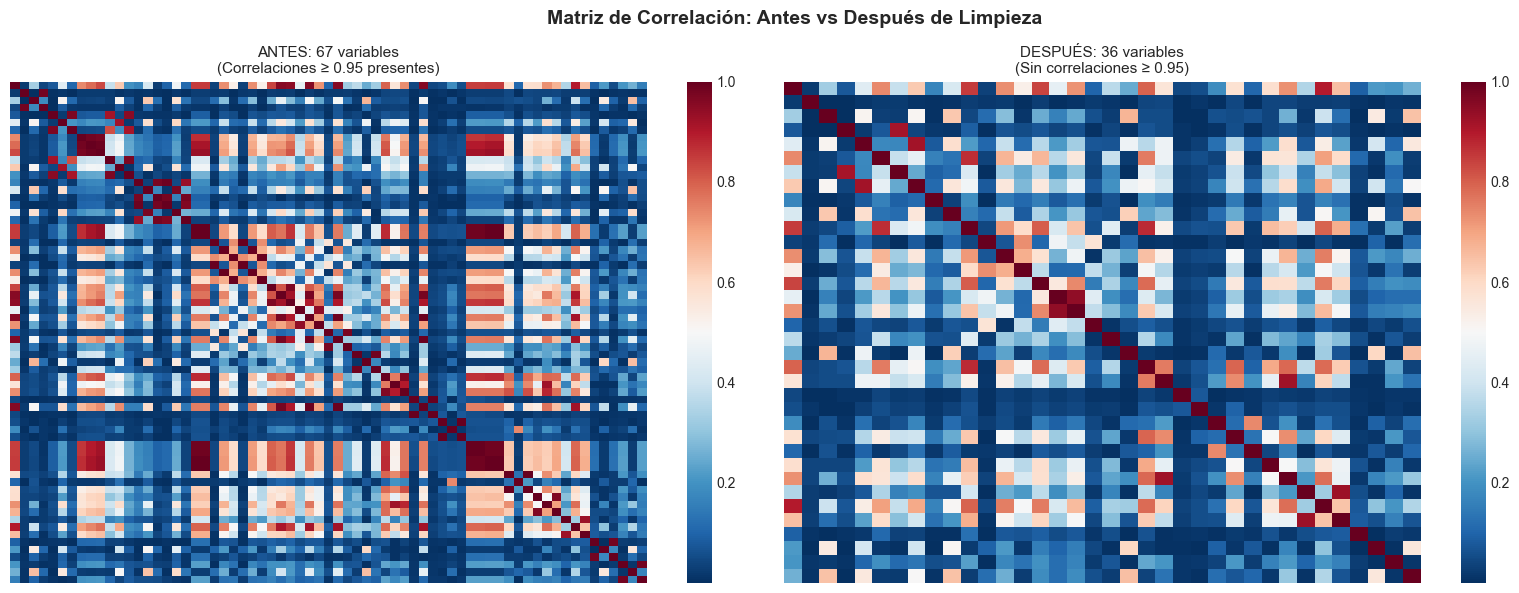


📊 Correlación máxima después de limpieza: 0.943


In [12]:
# ============================================================================
# 6.4 APLICAR ELIMINACIÓN Y VISUALIZAR RESULTADO
# ============================================================================

# Guardar dimensiones antes
shape_before_corr = df.shape

# Eliminar variables correlacionadas
df = df.drop(columns=list(vars_to_drop), errors='ignore')

print(f"\n✓ ELIMINACIÓN COMPLETADA")
print("="*60)
print(f"   Antes:  {shape_before_corr[1]} columnas")
print(f"   Después: {df.shape[1]} columnas")
print(f"   Eliminadas: {shape_before_corr[1] - df.shape[1]} columnas")

# Visualizar matriz de correlación después de limpieza
numeric_cols_after = df.select_dtypes(include='number').columns.tolist()
numeric_cols_after = [c for c in numeric_cols_after if c not in exclude_from_corr]

if len(numeric_cols_after) > 0:
    corr_after = df[numeric_cols_after].corr().abs()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Antes
    sns.heatmap(corr_matrix, ax=axes[0], cmap='RdBu_r', center=0.5,
                xticklabels=False, yticklabels=False)
    axes[0].set_title(f'ANTES: {len(corr_matrix)} variables\n(Correlaciones ≥ 0.95 presentes)', fontsize=11)
    
    # Después
    sns.heatmap(corr_after, ax=axes[1], cmap='RdBu_r', center=0.5,
                xticklabels=False, yticklabels=False)
    axes[1].set_title(f'DESPUÉS: {len(corr_after)} variables\n(Sin correlaciones ≥ 0.95)', fontsize=11)
    
    plt.suptitle('Matriz de Correlación: Antes vs Después de Limpieza', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Verificar que no quedan correlaciones altas
    max_corr_after = corr_after.where(np.triu(np.ones(corr_after.shape), k=1).astype(bool)).max().max()
    print(f"\n📊 Correlación máxima después de limpieza: {max_corr_after:.3f}")

## 7. Separación de Variables y Selección de Features

Separamos las columnas en tres categorías: identificadores (para trazabilidad), etiquetas (solo para evaluación posterior) y features numéricas (para los modelos).

In [13]:
# ============================================================================
# 7.1 DEFINIR COLUMNAS POR CATEGORÍA
# ============================================================================

# Identificadores (para trazabilidad)
id_cols = ['id.orig_h', 'window_start', 'window_end']
id_cols = [c for c in id_cols if c in df.columns]

# Etiquetas (variable objetivo - SOLO para evaluación)
label_cols = [c for c in df.columns if 'attack' in c.lower()]

# Features numéricas (excluir identificadores y etiquetas)
feature_cols = [c for c in df.columns if c not in id_cols + label_cols]

print("SEPARACIÓN DE COLUMNAS")
print("="*60)
print(f"\n📋 Identificadores ({len(id_cols)}):")
for col in id_cols:
    print(f"   • {col}")

print(f"\n📋 Etiquetas ({len(label_cols)}):")
for col in label_cols:
    print(f"   • {col}")

print(f"\n📋 Features numéricas: {len(feature_cols)} columnas")
print(f"   (Estas serán las variables de entrada para los modelos)")

SEPARACIÓN DE COLUMNAS

📋 Identificadores (3):
   • id.orig_h
   • window_start
   • window_end

📋 Etiquetas (6):
   • attack_phase_nunique
   • is_attack_count
   • is_attack_ratio
   • is_attack_any
   • is_attack_majority
   • is_attack

📋 Features numéricas: 36 columnas
   (Estas serán las variables de entrada para los modelos)


In [14]:
# ============================================================================
# 7.2 SEPARAR FEATURES Y ETIQUETAS
# ============================================================================

# Crear matriz de features X (excluyendo identificadores y etiquetas)
X = df.drop(columns=id_cols + label_cols, errors='ignore')

# Guardar etiqueta para evaluación (NO para entrenamiento)
y = df['is_attack'] if 'is_attack' in df.columns else df['is_attack_any']

print(f"\n📋 Features para modelado ({X.shape[1]}):")
print(f"   {list(X.columns)}")

print(f"\n{'='*60}")
print(f"RESUMEN DE SEPARACIÓN")
print(f"{'='*60}")
print(f"   Shape de features (X): {X.shape}")
print(f"   Shape de etiquetas (y): {y.shape}")
print(f"\n   Distribución de clases:")
print(f"   • Normal:  {(~y.astype(bool)).sum():,} ({(~y.astype(bool)).mean()*100:.1f}%)")
print(f"   • Ataque:  {y.astype(bool).sum():,} ({y.astype(bool).mean()*100:.1f}%)")


📋 Features para modelado (36):
   ['n_connections', 'id.orig_p_mean', 'id.orig_p_std', 'orig_bytes_mean', 'orig_bytes_std', 'resp_bytes_mean', 'bytes_ratio_mean', 'bytes_ratio_std', 'duration_mean', 'duration_std', 'conn_state_encoded_mean', 'conn_interval_mean', 'conn_interval_std', 'conn_interval_max', 'conn_count_10s_mean', 'conn_count_60s_mean', 'conn_count_60s_max', 'conn_count_300s_mean', 'interval_stddev_mean', 'interval_stddev_std', 'burst_score_mean', 'burst_score_std', 'total_conn_from_ip_mean', 'hour_of_day_mean', 'hour_of_day_std', 'ip_first_seen_hours_ago_mean', 'ip_first_seen_hours_ago_std', 'recon_pattern_score_mean', 'recon_pattern_score_std', 'recent_activity_score_mean', 'recent_activity_score_std', 'recent_activity_score_max', 'recent_docker_event_mean', 'recent_docker_event_std', 'time_since_container_start_mean', 'time_since_container_start_std']

RESUMEN DE SEPARACIÓN
   Shape de features (X): (24005, 36)
   Shape de etiquetas (y): (24005,)

   Distribución de cl

## 8. Exportación del Dataset Limpio

Guardamos el dataset preprocesado (limpio de variables constantes, baja varianza y altamente correlacionadas) junto con las etiquetas y metadatos.

In [17]:
import joblib
import os

# ============================================================================
# EXPORTAR DATASET PREPROCESADO (LIMPIO)
# ============================================================================

# 1. Dataset limpio con features (sin escalar)
X.to_csv('../../data/preprocessed_datasets/windowed_dataset_cleaned.csv', index=False)
print("✓ Dataset limpio guardado: ../../data/preprocessed_datasets/windowed_dataset_cleaned.csv")

# 2. Etiquetas (para evaluación posterior)
y.to_csv('../../data/preprocessed_datasets/y_labels.csv', index=False)
print("✓ Etiquetas guardadas: ../../data/preprocessed_datasets/y_labels.csv")
# 3. Metadatos (identificadores y columnas de contexto)
df_metadata = df[id_cols + label_cols]
df_metadata.to_csv('../../data/preprocessed_datasets/metadata.csv', index=False)
print("✓ Metadatos guardados: ../../data/preprocessed_datasets/metadata.csv")

✓ Dataset limpio guardado: ../../data/preprocessed_datasets/windowed_dataset_cleaned.csv
✓ Etiquetas guardadas: ../../data/preprocessed_datasets/y_labels.csv
✓ Metadatos guardados: ../../data/preprocessed_datasets/metadata.csv


In [ ]:
# Verificar archivos exportados
print("\n" + "=" * 70)
print("RESUMEN DE ARCHIVOS EXPORTADOS")
print("=" * 70)

# Datasets
print("\n📁 Datasets preprocesados:")
datasets = [
    '../../data/preprocessed_datasets/windowed_dataset_cleaned.csv',
    '../../data/preprocessed_datasets/y_labels.csv',
    '../../data/preprocessed_datasets/metadata.csv'
]
for path in datasets:
    size = os.path.getsize(path) / 1024 
    print(f"   {path}: {size:.1f} KB")



RESUMEN DE ARCHIVOS EXPORTADOS

📁 Datasets preprocesados:
   ../../data/preprocessed_datasets/windowed_dataset_cleaned.csv: 7115.0 KB
   ../../data/preprocessed_datasets/y_labels.csv: 70.3 KB
   ../../data/preprocessed_datasets/metadata.csv: 1479.5 KB


## 9. Resumen de Transformaciones Aplicadas

Resumen detallado de todas las transformaciones de limpieza aplicadas a los datos originales.

In [21]:
# Crear resumen detallado de transformaciones
print("=" * 80)
print("RESUMEN COMPLETO DEL PREPROCESAMIENTO")
print("=" * 80)

print("\nDATOS DE ENTRADA")
print("-" * 40)
print(f"   Archivo origen: windowed_dataset.csv")
print(f"   Dimensiones originales: {original_shape}")

print("\nTRANSFORMACIONES DE LIMPIEZA APLICADAS")
print("-" * 40)

print("\n   Eliminación de columnas constantes")
print(f"      - {len(constant_cols)} columnas eliminadas por tener un único valor")

print("\n   Eliminación de columnas con baja varianza")
print(f"      - {len(low_variance_cols)} columnas eliminadas (>99% mismo valor)")

print("\n   Tratamiento de valores nulos")
print(f"      - Columnas *_std: imputadas con 0 ({len(std_cols)} columnas)")
print(f"      - Columnas time_since_last_conn_*: imputadas con 0")
print(f"      - Columnas restantes: imputadas con mediana")

print("\n   Eliminación de variables altamente correlacionadas")
print(f"      - Umbral de correlación: {CORRELATION_THRESHOLD}")
print(f"      - {len(vars_to_drop)} columnas eliminadas por correlación ≥ {CORRELATION_THRESHOLD}")

print("\n   Separación de columnas")
print(f"      - Identificadores: {id_cols}")
print(f"      - Etiquetas: {label_cols}")
print(f"      - Features numéricas: {len(X.columns)} columnas")

print("\nDATOS DE SALIDA")
print("-" * 40)
print(f"   Dataset limpio:  windowed_dataset_cleaned.csv - Shape: {X.shape}")
print(f"   Etiquetas:       y_labels.csv                 - Shape: ({len(y)},)")
print(f"   Metadatos:       metadata.csv")

print("\nREDUCCIÓN DE DIMENSIONALIDAD")
print("-" * 40)
total_removed = original_shape[1] - X.shape[1] - len(id_cols) - len(label_cols)
print(f"   Columnas originales (features): {original_shape[1] - len(id_cols) - len(label_cols)}")
print(f"   Columnas finales (features):    {X.shape[1]}")
print(f"   Columnas eliminadas:            {total_removed}")

RESUMEN COMPLETO DEL PREPROCESAMIENTO

DATOS DE ENTRADA
----------------------------------------
   Archivo origen: windowed_dataset.csv
   Dimensiones originales: (24005, 94)

TRANSFORMACIONES DE LIMPIEZA APLICADAS
----------------------------------------

   Eliminación de columnas constantes
      - 11 columnas eliminadas por tener un único valor

   Eliminación de columnas con baja varianza
      - 7 columnas eliminadas (>99% mismo valor)

   Tratamiento de valores nulos
      - Columnas *_std: imputadas con 0 (20 columnas)
      - Columnas time_since_last_conn_*: imputadas con 0
      - Columnas restantes: imputadas con mediana

   Eliminación de variables altamente correlacionadas
      - Umbral de correlación: 0.95
      - 31 columnas eliminadas por correlación ≥ 0.95

   Separación de columnas
      - Identificadores: ['id.orig_h', 'window_start', 'window_end']
      - Etiquetas: ['attack_phase_nunique', 'is_attack_count', 'is_attack_ratio', 'is_attack_any', 'is_attack_majority

## 10. Conclusiones

### 10.1 Resumen del Preprocesamiento

El proceso de preprocesamiento ha limpiado el dataset de ventanas deslizantes (`windowed_dataset.csv`) eliminando variables que no aportan información útil para la detección de anomalías.

### 10.2 Pipeline de Limpieza Aplicado

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                         PIPELINE DE PREPROCESAMIENTO                        │
└─────────────────────────────────────────────────────────────────────────────┘
                                     │
                    ┌────────────────▼────────────────┐
                    │    1. Eliminación Constantes    │
                    │    (Variables con 1 único       │
                    │     valor - sin información)    │
                    └────────────────┬────────────────┘
                                     │
                    ┌────────────────▼────────────────┐
                    │   2. Eliminación Baja Varianza  │
                    │    (>99% mismo valor - casi     │
                    │         sin información)        │
                    └────────────────┬────────────────┘
                                     │
                    ┌────────────────▼────────────────┐
                    │   3. Tratamiento de Nulos       │
                    │    • *_std → 0 (std=0 para n=1) │
                    │    • Temporales → 0 (sin        │
                    │      historial)                 │
                    │    • Resto → mediana            │
                    └────────────────┬────────────────┘
                                     │
                    ┌────────────────▼────────────────┐
                    │  4. Eliminación Correlacionadas │
                    │    (Variables con ρ ≥ 0.95      │
                    │     son redundantes)            │
                    └────────────────┬────────────────┘
                                     │
                    ┌────────────────▼────────────────┐
                    │   5. Separación de Variables    │
                    │    • Identificadores (IPs,      │
                    │      timestamps)                │
                    │    • Etiquetas (solo eval)      │
                    │    • Features numéricas         │
                    └────────────────┬────────────────┘
                                     │
                    ┌────────────────▼────────────────┐
                    │   windowed_dataset_cleaned.csv  │
                    │    (Dataset limpio para         │
                    │     modelado)                   │
                    └─────────────────────────────────┘
```

### 10.3 Decisiones Clave Tomadas

**1. Eliminación de variables sin información (constantes + baja varianza)**
- Variables constantes no discriminan entre clases
- Variables con >99% mismo valor aportan información marginal
- Reducción de dimensionalidad mejora eficiencia

**2. Eliminación de variables redundantes (correlación ≥ 0.95)**
- Variables altamente correlacionadas proporcionan información redundante
- Mantener ambas puede causar inestabilidad numérica en algunos algoritmos
- Reducción de dimensionalidad sin pérdida significativa de información

**3. Preservación de outliers**
- Los outliers representan comportamientos anómalos (potenciales ataques)
- NO se eliminaron, ya que contienen la información que queremos detectar

**4. Tratamiento contextual de valores nulos**
- Los nulos en columnas `*_std` se imputaron con 0 (varianza nula para una única observación)
- Los nulos en métricas temporales se imputaron con 0 (primera conexión, sin historial)

**5. Sin escalado/normalización en este notebook**
- El escalado y normalización se realizará en cada notebook de modelado
- Cada algoritmo puede requerir transformaciones diferentes (RobustScaler, StandardScaler, PowerTransformer, etc.)

### 10.4 Artefactos Generados

Los siguientes archivos están listos para el modelado:

```
📁 data/processed/
├── windowed_dataset_cleaned.csv  # Features limpias (sin escalar)
├── y_labels.csv                  # Etiquetas (solo evaluación)
└── metadata.csv                  # Identificadores y contexto

📁 models/transformers/
└── feature_names.joblib          # Lista de features esperadas
```

### 10.5 Próximos Pasos

El preprocesamiento está completo y el dataset limpio está listo para:

1. **Notebook 03a_modeling_isolation_forest**: Aplicar escalado + entrenar modelo basado en árboles
2. **Notebook 03b_modeling_hdbscan**: Aplicar escalado + entrenar clustering basado en densidad  
3. **Notebook 03c_modeling_gmm**: Aplicar transformación + entrenar modelo de mezcla de gaussianas
4. **Notebook 04_validation_model_selection**: Comparar rendimiento de los tres modelos

### 10.6 Uso del Dataset Limpio

```python
# Ejemplo de carga del dataset limpio en notebooks de modelado
import pandas as pd
import joblib

# Cargar datos
X = pd.read_csv('data/processed/windowed_dataset_cleaned.csv')
y = pd.read_csv('data/processed/y_labels.csv')
feature_names = joblib.load('models/transformers/feature_names.joblib')

# Aplicar escalado específico para el modelo
# (cada notebook de modelado aplicará el escalado apropiado)
```

---
**Fin del Notebook de Preprocesamiento**